# NLP for Sentiment Analysis with Twitter Data

## Introduction

The goal of this project is to build a model that can classify the sentiment of a tweet based on its contents. 

The data used is sourced from Twitter from SXSW 2013, and contains tweets about the SXSW tech events and product announcements. Most of the tweets are about Apple and Google, and many mention specific products. The raw data can be found in the data folder in this repository.

The data was manually labeled for classification, and contains the tweet text, the product or brand mentioned, and the sentiment as interpreted by the labeler.


## Business Objective

The resulting model will be used to classify tweets from future tech conferences from Google and Apple, and analyze how sentiment for the brands has changed over time. 

I'll be evaluating my model based on accuracy score to understand how the model is performing holistically. 

## Data Exploration and Cleaning

After running all the relevant imports and the csv file, I can preview the dataset below.There are three columns, where the column describing the brand/product is mostly null. There is only one null in the tweet text column so I will drop that. 

In [1]:
import pandas as pd
import numpy as np

#visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud

#text processing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import re
import nltk
import string
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords

#modeling
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.naive_bayes import ComplementNB

import warnings
warnings.filterwarnings('ignore')

In [2]:
raw_data = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding = 'latin1')
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
tweet_text                                            9092 non-null object
emotion_in_tweet_is_directed_at                       3291 non-null object
is_there_an_emotion_directed_at_a_brand_or_product    9093 non-null object
dtypes: object(3)
memory usage: 213.2+ KB


In [3]:
# theres's only one null in the tweet text column so I'm dropping it here
raw_data = raw_data.drop(index=6, axis=0)
raw_data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


Taking a look at the subjects of the tweets, I can see they are labeled with several subcategories of Google and Apple products. However, most of this column is null values.  

In [4]:
raw_data['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

And looking at the sentiment, it looks like most of these are labeled as neutral and there are actually very few negative tweets. I assume this is because the tweets are from product announcements at SXSW, so the atmosphere is focused on excitement or news around new product launches. 

In [6]:
raw_data['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

I want to take a closer look at the 'I can't tell' category to see if I can group it in with neutral or if I should disregard. 

In [7]:
ct_df = raw_data[raw_data['is_there_an_emotion_directed_at_a_brand_or_product'] == 'I can\'t tell']
ct_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
90,Thanks to @mention for publishing the news of ...,NaN,I can't tell
102,ÛÏ@mention &quot;Apple has opened a pop-up st...,NaN,I can't tell
237,Just what America needs. RT @mention Google to...,NaN,I can't tell
341,The queue at the Apple Store in Austin is FOUR...,NaN,I can't tell
368,Hope it's better than wave RT @mention Buzz is...,NaN,I can't tell


Seems like a mixed bag. I'm going to drop these since there are already so many more neutrals and it would just contribute to the class imbalance. 

In [8]:
raw_data = raw_data.drop([row for row in ct_df.index])

I also want to preview the neutral tweets... and they look pretty neutral. So I'm going to create a new classifier column to sort these into: -1 for negative and 1 for positive. The neutrals will be the default 0.

In [9]:
ne_df = raw_data[raw_data['is_there_an_emotion_directed_at_a_brand_or_product'] == 'No emotion toward brand or product']
ne_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
16,Holler Gram for iPad on the iTunes App Store -...,NaN,No emotion toward brand or product
32,"Attn: All #SXSW frineds, @mention Register fo...",NaN,No emotion toward brand or product
33,Anyone at #sxsw want to sell their old iPad?,NaN,No emotion toward brand or product
34,Anyone at #SXSW who bought the new iPad want ...,NaN,No emotion toward brand or product


In [10]:
#creating a new column for multiclass problem
raw_data['class'] = 0
for row in raw_data.index:
    if raw_data['is_there_an_emotion_directed_at_a_brand_or_product'][row] == 'Positive emotion':
        raw_data['class'][row] = 1
    elif raw_data['is_there_an_emotion_directed_at_a_brand_or_product'][row] == 'Negative emotion':
        raw_data['class'][row] = -1
        
raw_data.head(6)

C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,class
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,-1
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,1
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,1
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,-1
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,1
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product,0
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion,1
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion,1
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion,1
10,Excited to meet the @samsungmobileus at #sxsw ...,Android,Positive emotion,1


As noted, the classes are pretty imbalanced. This could become a problem when working through the modeling so I will keep this in mind. 

I can also see that most of the neutral tweets also don't have product labels associated so they really aren't contributing much information. Ultimately, I want to keep the neutral tweets in the data that I use because without them the data set would be really small.

In [171]:
nulls_df = raw_data[raw_data['emotion_in_tweet_is_directed_at'].isna()]
nulls_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,class,clean_tweet,Brand Mentioned


In order to visualize how sentiment differs by the brands in this data set, I'll put together a visual. First, I need to fill NAs. Then to make it look cleaner, I'm going to sort all the sub products into just Google or Apple.

In [116]:
#creating a new clean column
raw_data['Brand Mentioned'] = raw_data['emotion_in_tweet_is_directed_at'].fillna('unspecified')

In [161]:
# using lambda function to sort all the subcategories into their respective brand

raw_data['Brand Mentioned'] = raw_data['emotion_in_tweet_is_directed_at'].map(
    lambda x: x.replace("Other Apple product or service" and "iPad" and "Apple or iPhone App" and "Apple or Apple App" and "iPhone", "Apple"))
raw_data['Brand Mentioned'] = raw_data['emotion_in_tweet_is_directed_at'].map(
    lambda x: x.replace("Apple or Apple App", "Apple"))
raw_data['Brand Mentioned'] = raw_data['emotion_in_tweet_is_directed_at'].map(
    lambda x: x.replace("Android", "Google"))
raw_data['Brand Mentioned'] = raw_data['emotion_in_tweet_is_directed_at'].map(
    lambda x: x.replace("Other Google product or service" and "Android" and "Android App", "Google"))

In [162]:
#using a groupby to grab the product and sentiment
grouped = raw_data.groupby(['class', 'Brand Mentioned', ]).count()[
    'is_there_an_emotion_directed_at_a_brand_or_product']

<Figure size 1800x1080 with 0 Axes>

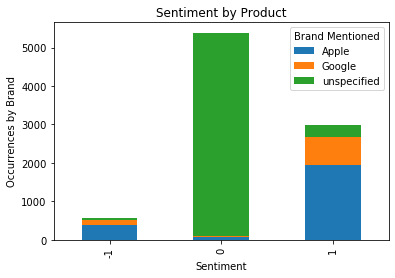

In [163]:
plt.figure(figsize=(25, 15))
fig = test.unstack().plot(kind='bar', stacked=True, align="center")

fig.set_title('Sentiment by Product')

fig.set_xlabel('Sentiment')
fig.set_ylabel('Occurrences by Brand')

plt.savefig('Images/sentiment_bars')

As we can see, a majority of the neutral tweets arent labeled by product. Of the negatives and positives, the majority are about Apple products. The chart suggests that sentiment doesn't necessarily differ for each brand, but overall conversation tends to be more about Apple. 

## Preprocessing

I'm going to start a new column for processed text. The first step I am going to take is to remove handles, since they aren't actual content and shouldn't convey tone. 

I'm using regex to grab these as well as URLs replace them with nothing. The example below shows they have been removed!

In [25]:
raw_data['clean_tweet'] = [re.sub(r'(http://[^"\s]+)|(@\w+)', '', tweet) for tweet in raw_data['tweet_text']]

In [26]:
print(raw_data.iloc[14][0])
print(raw_data.iloc[14][4])

haha, awesomely rad iPad app by @madebymany http://bit.ly/hTdFim #hollergram #sxsw
haha, awesomely rad iPad app by   #hollergram #sxsw


Now, I can compile a list of stopwords from NLTK so I can remove all the filler words in the text that don't actually contain any information. This will also remove punctuation for when the tweets are tokenized, so the hashtags can be read as words. 

In [27]:
stopwords_list = stopwords.words('english')
stopwords_list += string.punctuation
punct_list = ["''", '""', '...', '``']
stopwords_list += punct_list

Before I move into modeling, I am going to take a look at what my data will contain when tokenized. I can see that punctuation has been removed and each tweet has transformed into a list of its most meaningful words.

In [28]:
# this function will lowercase everything and remove stopwords and punctuation

def process_tweet(tweet):
    tokens = nltk.word_tokenize(tweet)
    words_lower = [token.lower() for token in tokens]
    words_stopped = [word for word in words_lower if word not in stopwords_list]
    return words_stopped

#previewing the results
processed_data = list(map(process_tweet, raw_data['clean_tweet']))

processed_data[0]

In [30]:
#creating a list of unique words in the data set

total_vocab = set()
for token in processed_data:
    total_vocab.update(token)
    
print(len(total_vocab))

10444


In this set with stop words removed there are 10,444 unique words.

I'll compile a frequency dictionary to take a look at the most common words. Some of the most frequent are general Twitter words - 'rt', 'link'. Many however are referring to products and events.

In [31]:
tweet_concat = []
for tweet in processed_data:
    tweet_concat += tweet
    
tweet_freqdist = FreqDist(tweet_concat)
tweet_freqdist.most_common(2000)

[('sxsw', 9352),
 ('link', 4265),
 ('rt', 2926),
 ('google', 2543),
 ('ipad', 2402),
 ('apple', 2267),
 ('quot', 1657),
 ('iphone', 1497),
 ('store', 1455),
 ("'s", 1218),
 ('2', 1104),
 ('new', 1078),
 ('austin', 948),
 ('amp', 834),
 ('app', 811),
 ('launch', 647),
 ('social', 636),
 ('circles', 634),
 ('android', 572),
 ('today', 572),
 ("n't", 467),
 ('network', 458),
 ('ipad2', 455),
 ('pop-up', 411),
 ('via', 405),
 ('line', 393),
 ('free', 387),
 ('get', 383),
 ('called', 354),
 ('party', 345),
 ('mobile', 337),
 ('sxswi', 337),
 ('one', 305),
 ('major', 300),
 ('like', 280),
 ('time', 270),
 ("'re", 262),
 ('temporary', 262),
 ('opening', 256),
 ("'m", 252),
 ('possibly', 236),
 ('downtown', 225),
 ('people', 223),
 ('apps', 222),
 ('great', 221),
 ('see', 218),
 ('maps', 216),
 ('day', 216),
 ('check', 215),
 ('mayer', 214),
 ('going', 213),
 ('open', 209),
 ('popup', 208),
 ('need', 202),
 ('go', 197),
 ('marissa', 189),
 ('got', 182),
 ('know', 181),
 ('w/', 181),
 ('come', 

To get a better visual, I'll generate a word cloud so we can see what everyone's talking about:

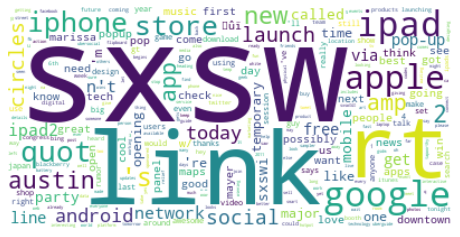

In [176]:
#instantiating word cloud and using my frequency dictionary to fill it in
wc = WordCloud(background_color="white", max_words=2000)
wc.generate_from_frequencies(tweet_freqdist)

plt.figure(figsize=(8,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.margins(x=1, y=1)
plt.show()

# wc.to_file('Images/word_cloud.png')

## Modeling with Classifiers

Now that I have a thorough understanding of the data, I'm going to test out different classifiers to see how effective they are. I'll start with Multinomial Naive Bayes as my baseline model, as this is commonly used for NLP.

### Baseline Model: Multinomial Naive Bayes with Count Vectorizer

I'll also use a count vectorizer with this baseline model since it's one of the more simple techniques. Count Vectorizer converts text into a vector based on the count of each word occuring in the text. 

I'll pull in my cleaned text that I defined above and fit to train and test variables. 

In [34]:
X = raw_data['clean_tweet']
y = raw_data['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

In [35]:
count_vectorizer = CountVectorizer(stop_words=stopwords_list)

X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

Now I'll instantiate the classifier and fit it to the vectorized variables. I am defining a function to easily return the score of the classifier as well as a confusion matrix so I can compare performance of different models. 

In [36]:
nb_classifier = MultinomialNB()

nb_classifier.fit(X_train_count, y_train)

MultinomialNB()

In [37]:
def score(clf, X_train, y_train, X_test, y_test):
  
    """ 

    This function streamlines evaluating a model by generating
    predictions for train and test sets and printing their accuracy scores
    as well as a confusion matrix of the test results. Inputs needed are 
    the fitted model, and X and y variables from a train-test-split

    """

    train_preds = clf.predict(X_train)
    test_preds = clf.predict(X_test)
    train_score = accuracy_score(y_train, train_preds)
    test_score = accuracy_score(y_test, test_preds)
    print('test accuracy score =', test_score,
          'train accuracy score =', train_score)
    plot_confusion_matrix(clf, X_test, y_test)

test accuracy score = 0.658012533572068 train accuracy score = 0.8285586392121754


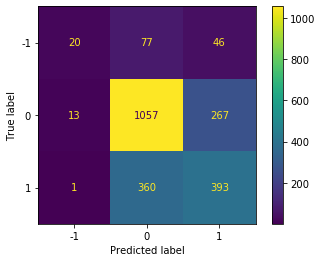

In [38]:
#testing function on MNB
score(nb_classifier, X_train_count, y_train, X_test_count, y_test)

My first model is quite overfit, and it may be having trouble learning because the classes are so imbalanced. The next thing I'm going to try is changing to a TF-IDF vectorizer, which penalizes words that show up more frequently. This could help the model value words like sxsw, google, and apple less, and instead actually look for words that indicate sentiment.

### MNB with TF-IDF

As a starting point, I'm setting the TF-IDF vectorizer to ignore terms that appear in more than 90% of the tweets. 

In [39]:
tfidf = TfidfVectorizer(stop_words=stopwords_list, 
                        max_df = .90, 
                        use_idf=True)

tfidf_train = tfidf.fit_transform(X_train)
tfidf_test = tfidf.transform(X_test)

Pulling out a random example, I can see that more unique words are rising to the top where more common words like apple, sxsw, and austin are towards the bottom as expected.

In [181]:
#creating a dataframe so I can preview the results of TF-IDF
tfidf_test_df = pd.DataFrame(tfidf_test.toarray(), columns=tfidf.get_feature_names())

# Grabbing a vectorized row
test_doc = tfidf_test_df.iloc[8]
print(test_doc.loc[test_doc > 0].sort_values(ascending=False)) # Showing values > 0

ignite        0.479958
spots         0.422123
hot           0.344930
gowalla       0.339182
convention    0.332380
right         0.277836
party         0.224531
sxswi         0.224121
austin        0.174040
store         0.148700
apple         0.129289
Name: 8, dtype: float64


In [42]:
#instantiating another MNB classifier for TF-IDF
nb_tfidf = MultinomialNB()

nb_tfidf.fit(tfidf_train, y_train)

MultinomialNB()

test accuracy score = 0.6459265890778872 train accuracy score = 0.7660399880632647


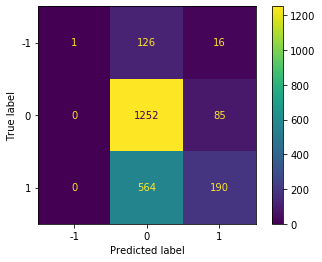

In [43]:
score(nb_tfidf, tfidf_train, y_train, tfidf_test, y_test)

This model is less overfit, and it seems to be learning some patterns, but it's still not good. It only correctly predicted one negative. The test score actually went down as well, so I'm going to try another type of classifier.

### Complement Naive Bayes

Complement Naive Bayes is similar to MNB, but is adapted to suit imbalanced data sets as it uses the complement of each class to compute the model’s weights. According to SciKit learn documentation, CNB regularly outperforms MNB on text classification tasks. Below, I am running this with TF-IDF-transformed variables.

In [44]:
#instantiating and fiting CNB
cnb = ComplementNB()

cnb.fit(tfidf_train, y_train)

ComplementNB()

test accuracy score = 0.6432408236347359 train accuracy score = 0.8222918531781558


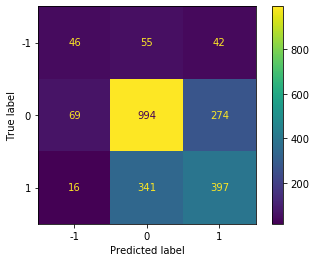

In [45]:
score(cnb, tfidf_train, y_train, tfidf_test, y_test)

CNB barely increased the test score, but made the model even more overfit! I'm going to try something different.

### Support Vector Machines

SVMs are said to help reduce overfitting, and SVC has a regularization parameter C which can be tuned. There are also different kernel types that can be applied. 

After exploring different values for C, I am able to reduce overfitting, which is a strength of using this model type. 

test accuracy score = 0.6754700089525515 train accuracy score = 0.8439271859146523


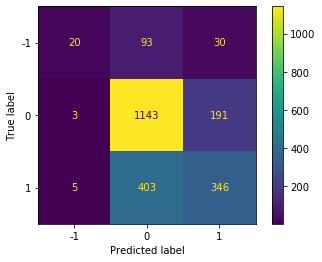

In [46]:
#starting with 1
svc_clf = SVC(kernel= 'linear', C=1)
svc_clf.fit(tfidf_train, y_train)
score(svc_clf, tfidf_train, y_train, tfidf_test, y_test)

test accuracy score = 0.6678603401969562 train accuracy score = 0.7730528200537153


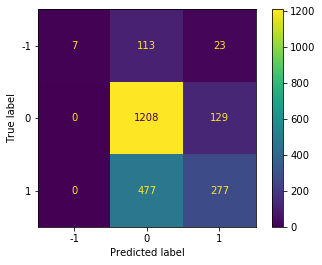

In [47]:
#reducing to 0.5 = stronger regulation
svc_clf = SVC(kernel= 'linear', C=0.5)
svc_clf.fit(tfidf_train, y_train)
score(svc_clf, tfidf_train, y_train, tfidf_test, y_test)

test accuracy score = 0.640107430617726 train accuracy score = 0.6674127126230975


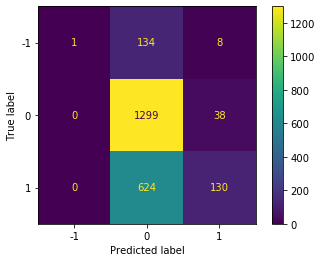

In [182]:
#still overfit! reducing a bit more
svc_clf = SVC(kernel= 'linear', C=0.2)
svc_clf.fit(tfidf_train, y_train)
score(svc_clf, tfidf_train, y_train, tfidf_test, y_test)
plt.savefig('Images/confusion_matrix')

The tradeoff to reducing overfitting in this model is that the accuracy score was sacrificed. It's predicting almost everything as a zero. My highest accuracy score out of all the classifiers I've run so far is about 84%, so I wouldn't want to move forward with any of these. 

## Modeling with Deep Learning

Since these classifiers aren't seeing great results, I'm going to take this a step further with pre-trained word embeddings and neural networks.

### GloVe

Global Vectors for Word Representation is a pre-trained model by the Stanford NLP Group, trained on massive data sets to obtain vector representations for words. To use it I will need to leverage keras, and import the glove text file.

In [49]:
#imports for keras/tensorflow to use gloVe with neural nets
from gensim.models import Word2Vec
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint

C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [50]:
#opening glove file and applying it to my data
glove = {}
with open('data/glove.6B.50d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocab:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

GloVe has vectorized the words in my data set:

In [51]:
glove['sxsw']

array([-0.54213  , -0.40598  , -0.57972  ,  0.68902  , -1.2828   ,
       -1.4274   , -0.3113   , -0.37996  ,  0.85759  ,  0.74349  ,
       -0.27944  , -1.2856   ,  0.30916  ,  0.10983  ,  0.76612  ,
        0.052707 , -0.045862 ,  0.97209  , -0.388    ,  0.0061045,
        0.36166  ,  0.063978 ,  0.60576  ,  1.1596   , -0.22204  ,
        0.55524  , -1.1646   , -0.11687  , -1.2104   , -0.90578  ,
        0.36391  ,  0.20946  , -0.19362  , -0.99614  , -0.18209  ,
       -0.13782  ,  0.2144   , -0.038234 , -0.29907  , -0.39556  ,
       -0.61547  ,  0.1485   , -1.0864   , -0.42129  , -0.42307  ,
        0.51809  ,  1.0751   , -0.30472  , -1.4201   ,  1.007    ],
      dtype=float32)

Now I'm going to define a class to create mean word embeddings:

In [52]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
    
    # adding a 'fit' method so I can use in a pipeline
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

Here I'm going to use Keras' preprocessing tools to tokenize each example, convert them to sequences, and then pad the sequences so they're all the same length.

In [53]:
tokenizer = text.Tokenizer(num_words=10000)
tokenizer.fit_on_texts(list(X_train))
X_train_tokenized = tokenizer.texts_to_sequences(X_train)
X_test_tokenized = tokenizer.texts_to_sequences(X_test)
X_train_token = sequence.pad_sequences(X_train_tokenized, maxlen=100)
X_test_token = sequence.pad_sequences(X_test_tokenized, maxlen=100)

In [54]:
#checking the shape of my X
X_train_token.shape

(6702, 100)

I'll also need to encode my y for the 3 classes:

In [56]:
#encoding the y so the shapes are compatible
y_train_enc = pd.get_dummies(y_train).values
y_test_enc = pd.get_dummies(y_test).values
y_train_enc.shape

(6702, 3)

Both variables appear to be the right dimesions. Time to try a neural net. I'm going to build a sequential model, starting with an embedding layer of 10,000 words, which is the number of words in the tokenizer. I'm setting the embedding size as 100 which is the max length parameter I used above.

I am then adding two layers, an LSTM and dense layers. To keep it simple, I'm going to run this for 3 epochs. 

My model will evaluate on accuracy, and use the selected loss function and optimizer. 

### Building a Neural Net

In [57]:
np.random.seed(10)
model1 = Sequential()

In [58]:
embedding_size = 100
model1.add(Embedding(10000, embedding_size))
model1.add(LSTM(25, return_sequences=True))
model1.add(GlobalMaxPool1D())
model1.add(Dense(50, activation='relu'))
model1.add(Dense(3, activation='relu'))

In [59]:
model1.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1000000   
_________________________________________________________________
lstm (LSTM)                  (None, None, 25)          12600     
_________________________________________________________________
global_max_pooling1d (Global (None, 25)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                1300      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 153       
Total params: 1,014,053
Trainable params: 1,014,053
Non-trainable params: 0
_________________________________________________________________


In [60]:
model_val = model1.fit(X_train_token, y_train_enc, epochs=3, batch_size=32, validation_split=0.1)

Epoch 1/3
189/189 [==============================] - 25s 106ms/step - loss: 0.9417 - accuracy: 0.5308 - val_loss: 0.7439 - val_accuracy: 0.6617
Epoch 2/3
189/189 [==============================] - 17s 90ms/step - loss: 0.7351 - accuracy: 0.7090 - val_loss: 0.7738 - val_accuracy: 0.6542
Epoch 3/3
189/189 [==============================] - 17s 91ms/step - loss: 0.5793 - accuracy: 0.7723 - val_loss: 0.8663 - val_accuracy: 0.6692


Within the three iterations, this model already improved its accuracy a lot. I'm going to build another function to evaluate neural net performance. 

In [61]:
def evaluate_nn(model, X_train, X_test, y_train, y_test):
    
    """ 

    This function takes in a fitted neural net and uses the evaluate function to 
    return performance for train and test sets in an easy to read format

    """
        
    results_train = model.evaluate(X_train_token, y_train_enc)
    results_test = model.evaluate(X_test_token, y_test_enc)

    print('----------')
    print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
    print('----------')
    print(f'Test Loss: {results_test[0]:.3} \nTest Accuracy: {results_test[1]:.3}')

In [62]:
#plugging my 'baseline' neural net into this function
evaluate_nn(model1, X_train_token, X_test_token, y_train_enc, y_test_enc)

70/70 [==============================] - 1s 21ms/step - loss: 1.0323 - accuracy: 0.6356 0s - loss: 1.0
----------
Training Loss: 0.569 
Training Accuracy: 0.711
----------
Test Loss: 1.03 
Test Accuracy: 0.636


These scores aren't too bad for a baseline. As a next step, I'm going to add more layers, and run for more epochs. In an attempt to add regularization parameters, I'm going to add dropout layers to hopefully make the model less sensitive to variance seeing as it's also overfit.

In [63]:
#new model with dropout layers
np.random.seed(10)
model2 = Sequential()

model2.add(Embedding(10000, embedding_size))
model2.add(LSTM(25, return_sequences=True))
model2.add(GlobalMaxPool1D())
model2.add(Dropout(0.5))
model2.add(Dense(50, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(3, activation='softmax'))

In [64]:
model2.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [65]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 25)          12600     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 25)                0         
_________________________________________________________________
dropout (Dropout)            (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                1300      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                

In [66]:
#increasing epochs to 6
model2_val = model2.fit(X_train_token, y_train_enc, epochs=6, batch_size=32)

Epoch 1/6
210/210 [==============================] - 22s 85ms/step - loss: 0.9526 - accuracy: 0.5563
Epoch 2/6
210/210 [==============================] - 18s 86ms/step - loss: 0.8362 - accuracy: 0.6053
Epoch 3/6
210/210 [==============================] - 18s 85ms/step - loss: 0.7177 - accuracy: 0.6909
Epoch 4/6
210/210 [==============================] - 18s 88ms/step - loss: 0.5651 - accuracy: 0.7758
Epoch 5/6
210/210 [==============================] - 19s 89ms/step - loss: 0.4697 - accuracy: 0.8121
Epoch 6/6
210/210 [==============================] - 18s 88ms/step - loss: 0.3895 - accuracy: 0.8442


In [67]:
evaluate_nn(model2, X_train_token, X_test_token, y_train_enc, y_test_enc)

70/70 [==============================] - 1s 20ms/step - loss: 0.9970 - accuracy: 0.6491
----------
Training Loss: 0.286 
Training Accuracy: 0.9
----------
Test Loss: 0.997 
Test Accuracy: 0.649


The accuracy score improved pretty quickly, but it appears that the neural net is still really struggling with the test set. 

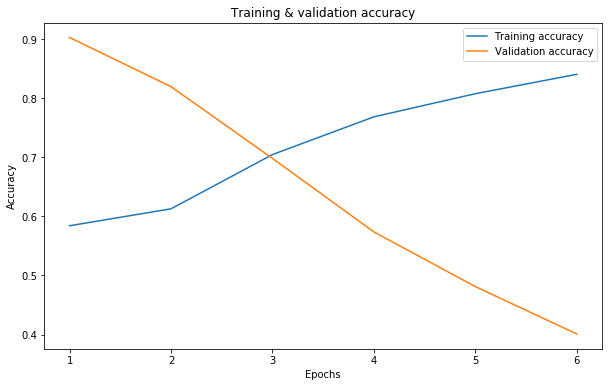

In [69]:
# Access the history attribute and store the dictionary
baseline_model_val_dict = model2_val.history

fig, ax = plt.subplots(figsize=(10, 6))

acc_values = baseline_model_val_dict['accuracy']
loss_values = baseline_model_val_dict['loss']

epochs = range(1, len(loss_values) + 1)
ax.plot(epochs, acc_values, label='Training accuracy')
ax.plot(epochs, loss_values, label='Validation accuracy')

ax.set_title('Training & validation accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend();

There are still many options I can tap into to improve performance. As a next step, I'm going to apply, L2 regularization and run many more epochs. I'll also add early stopping so I don't have an unnecessary amount of runtime. 

### Using L2 Regularization

In [70]:
early_stopping = [EarlyStopping(monitor='accuracy', patience=10)]

In [71]:
#applying L2 regularization layer
np.random.seed(10)
l2_model = Sequential()

l2_model.add(Embedding(10000, embedding_size))
l2_model.add(LSTM(25, return_sequences=True))
l2_model.add(GlobalMaxPool1D())
l2_model.add(Dropout(0.5))
l2_model.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
l2_model.add(Dropout(0.5))
l2_model.add(Dense(3, activation='softmax'))

In [72]:
l2_model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [73]:
#increasing epochs to 150
l2_model_val = l2_model.fit(X_train_token, y_train_enc, 
                            epochs=150, 
                            batch_size=256, 
                            callbacks=early_stopping)


Epoch 1/150
27/27 [==============================] - 10s 223ms/step - loss: 1.1993 - accuracy: 0.4975
Epoch 2/150
27/27 [==============================] - 6s 214ms/step - loss: 1.0325 - accuracy: 0.5763
Epoch 3/150
27/27 [==============================] - 6s 215ms/step - loss: 0.9842 - accuracy: 0.5753
Epoch 4/150
27/27 [==============================] - 6s 210ms/step - loss: 0.9526 - accuracy: 0.5936
Epoch 5/150
27/27 [==============================] - 6s 213ms/step - loss: 0.9283 - accuracy: 0.6053
Epoch 6/150
27/27 [==============================] - 6s 208ms/step - loss: 0.9183 - accuracy: 0.6013
Epoch 7/150
27/27 [==============================] - 6s 208ms/step - loss: 0.8878 - accuracy: 0.6084
Epoch 8/150
27/27 [==============================] - 6s 209ms/step - loss: 0.8532 - accuracy: 0.6022
Epoch 9/150
27/27 [==============================] - 6s 215ms/step - loss: 0.7814 - accuracy: 0.6567
Epoch 10/150
27/27 [==============================] - 6s 213ms/step - loss: 0.6947 - accur

Epoch 81/150
27/27 [==============================] - 6s 211ms/step - loss: 0.0895 - accuracy: 0.9714
Epoch 82/150
27/27 [==============================] - 6s 230ms/step - loss: 0.0930 - accuracy: 0.9721
Epoch 83/150
27/27 [==============================] - 6s 237ms/step - loss: 0.0920 - accuracy: 0.9708
Epoch 84/150
27/27 [==============================] - 6s 232ms/step - loss: 0.0892 - accuracy: 0.9736
Epoch 85/150
27/27 [==============================] - 6s 227ms/step - loss: 0.0786 - accuracy: 0.9756
Epoch 86/150
27/27 [==============================] - 6s 224ms/step - loss: 0.0801 - accuracy: 0.9764
Epoch 87/150
27/27 [==============================] - 6s 230ms/step - loss: 0.0804 - accuracy: 0.9757
Epoch 88/150
27/27 [==============================] - 6s 215ms/step - loss: 0.0828 - accuracy: 0.9726
Epoch 89/150
27/27 [==============================] - 6s 216ms/step - loss: 0.0852 - accuracy: 0.9748
Epoch 90/150
27/27 [==============================] - 6s 215ms/step - loss: 0.0813

In [74]:
evaluate_nn(l2_model, X_train_token, X_test_token, y_train_enc, y_test_enc)

70/70 [==============================] - 2s 22ms/step - loss: 2.4502 - accuracy: 0.6379
----------
Training Loss: 0.051 
Training Accuracy: 0.985
----------
Test Loss: 2.45 
Test Accuracy: 0.638


I am now at the point where my training score is very satisfactory, but the regularization is not really helping to improve my test score. I can also try L1 regularization.

### Using L1 regularization

In [75]:
#adding L1 regulairzer layer
np.random.seed(10)
l1_model = Sequential()

l1_model.add(Embedding(10000, embedding_size))
l1_model.add(LSTM(25, return_sequences=True))
l1_model.add(GlobalMaxPool1D())
l1_model.add(Dropout(0.5))
l1_model.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l1(0.005)))
l1_model.add(Dropout(0.5))
l1_model.add(Dense(3, activation='softmax'))

In [76]:
l1_model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [77]:
l1_model_val = l1_model.fit(X_train_token, y_train_enc, 
                            epochs=150, 
                            batch_size=256, 
                            callbacks=early_stopping)

Epoch 1/150
27/27 [==============================] - 10s 212ms/step - loss: 1.9052 - accuracy: 0.5375
Epoch 2/150
27/27 [==============================] - 6s 216ms/step - loss: 1.6186 - accuracy: 0.6025
Epoch 3/150
27/27 [==============================] - 6s 212ms/step - loss: 1.4736 - accuracy: 0.5927
Epoch 4/150
27/27 [==============================] - 6s 215ms/step - loss: 1.3546 - accuracy: 0.6003
Epoch 5/150
27/27 [==============================] - 6s 231ms/step - loss: 1.2319 - accuracy: 0.6086
Epoch 6/150
27/27 [==============================] - 6s 220ms/step - loss: 1.1365 - accuracy: 0.5990
Epoch 7/150
27/27 [==============================] - 6s 216ms/step - loss: 1.0433 - accuracy: 0.6125
Epoch 8/150
27/27 [==============================] - 6s 216ms/step - loss: 0.9551 - accuracy: 0.6170
Epoch 9/150
27/27 [==============================] - 6s 213ms/step - loss: 0.8395 - accuracy: 0.6965
Epoch 10/150
27/27 [==============================] - 6s 216ms/step - loss: 0.7354 - accur

27/27 [==============================] - 4s 137ms/step - loss: 0.2478 - accuracy: 0.9363
Epoch 81/150
27/27 [==============================] - 3s 125ms/step - loss: 0.2358 - accuracy: 0.9381
Epoch 82/150
27/27 [==============================] - 3s 128ms/step - loss: 0.2324 - accuracy: 0.9353
Epoch 83/150
27/27 [==============================] - 4s 142ms/step - loss: 0.2198 - accuracy: 0.9454
Epoch 84/150
27/27 [==============================] - 4s 145ms/step - loss: 0.2221 - accuracy: 0.9415
Epoch 85/150
27/27 [==============================] - 4s 131ms/step - loss: 0.2263 - accuracy: 0.9424
Epoch 86/150
27/27 [==============================] - 4s 133ms/step - loss: 0.2176 - accuracy: 0.9489
Epoch 87/150
27/27 [==============================] - 3s 127ms/step - loss: 0.2088 - accuracy: 0.9526
Epoch 88/150
27/27 [==============================] - 3s 129ms/step - loss: 0.2086 - accuracy: 0.9497
Epoch 89/150
27/27 [==============================] - 4s 131ms/step - loss: 0.2139 - accuracy: 

In [78]:
evaluate_nn(l1_model, X_train_token, X_test_token, y_train_enc, y_test_enc)

70/70 [==============================] - 1s 17ms/step - loss: 2.0770 - accuracy: 0.6531
----------
Training Loss: 0.0934 
Training Accuracy: 0.986
----------
Test Loss: 2.08 
Test Accuracy: 0.653


It looks like applying L1 did just a little bit better. Because the accuracy score outperformed any of the more standard classifiers, I will use this very last model as my final model. 

## Evaluation

Out of all the iterations of models that I tried, the neural nets using GloVe were most sucessful in achieving high accuracy. However, after trying several different techniques, the overfitting problem still didn't improve too much. 

My final neural net achieved 98.6% accuracy on the training set but 65.3% on the test set. I would recommend moving forward with this model to evaluate sentiment around future events and conferences related to tech as it has learned off of a specified data set. 

## Conclusions/Future Work

This data set presented the challenge of a pretty extreme class imbalance. Since the majority of samples were labeled as neutral, there were fewer indicators of sentiment. 

The classifiers typically used for text data don't have as many hyper-parameters that can be tuned to correct for class imbalance. Compliment Naive Bayes was applied to help with this, and and SVM model was used in hopes of reducing overfitting. However the most satisfactory results came from the neural net. 

In order to improve this model and make in more generalizable, it is recommended to gather more data that has a higher percentage of labels that indicate positive or negative sentiment. Adding more data could also allow the use of a simpler neural net model, which could help to reduce runtimes. 


## Thank you!